<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/06_pytorch_transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:** 

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. 
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# # Try to import the going_modular directory, download it from GitHub if it doesn't work
# try:
#     from going_modular.going_modular import data_setup, engine
# except:
#     # Get the going_modular scripts
#     print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
#     !git clone https://github.com/mrdbourke/pytorch-deep-learning
#     !mv pytorch-deep-learning/going_modular .
#     !rm -rf pytorch-deep-learning
#     from going_modular.going_modular import data_setup, engine

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data 

In [3]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

data\pizza_steak_sushi directory exists.


### Prepare data

In [6]:
import data_setup, engine

In [7]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [8]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1dd43d48370>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [9]:
# Setup the model with pretrained weights and send it to the target device 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_0 = torchvision.models.efficientnet_b0(weights=weights).to(device)

#model_0 # uncomment to output (it's very long)
model_0

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [10]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [11]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [12]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [13]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0900 | train_acc: 0.4336 | test_loss: 0.9146 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8715 | train_acc: 0.7578 | test_loss: 0.8012 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7786 | train_acc: 0.7695 | test_loss: 0.7366 | test_acc: 0.8040
Epoch: 4 | train_loss: 0.7171 | train_acc: 0.7578 | test_loss: 0.6486 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6444 | train_acc: 0.7578 | test_loss: 0.6265 | test_acc: 0.8968
[INFO] Total training time: 119.723 seconds


### Make predictions on the entire test dataset with the model

In [19]:
# 2. Your corrected inference loop
y_preds = [] # Create an empty list to store predictions
y_true = []
model_0.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        # Data is already transformed by the DataLoader
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_logits = model_0(X)

        # 2. Calculate prediction labels
        y_pred_labels = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

        # 3. Append the batch predictions to our list
        y_preds.append(y_pred_labels.cpu()) # Move to CPU to avoid filling up GPU memory

        y_true.append(y.cpu())

# 4. Concatenate all batch predictions into a single tensor
all_predictions = torch.cat(y_preds)
true_labels = torch.cat(y_true)
print(all_predictions)
print(true_labels)

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])


### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [20]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.4


In [21]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.4


In [22]:
# TODO
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=all_predictions, 
                        target=true_labels)

confmat_tensor

tensor([[20,  3,  2],
        [ 0, 19,  0],
        [ 0,  3, 28]])

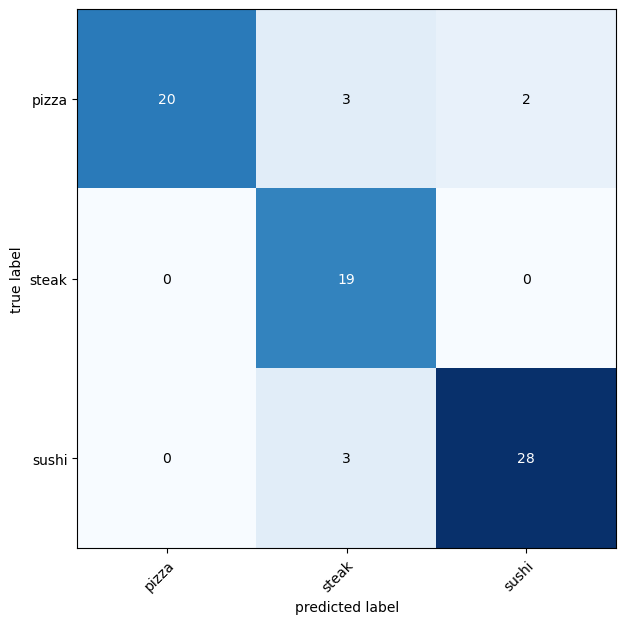

In [23]:
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with numpy
    class_names=class_names,
    figsize=(10, 7)
)

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [48]:
# Get all test data paths
from tqdm.auto import tqdm
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Get prediction and prediction probability
    from PIL import Image
    img = Image.open(path) # open image
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the CPU 
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class
  
    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=model_0,
                                 transform=simple_transform,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts[:5]

  0%|          | 0/75 [00:00<?, ?it/s]

[{'image_path': WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.7468212842941284,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.6038060784339905,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.46725475788116455,
  'pred_class': 'steak',
  'correct': False},
 {'image_path': WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.78311687707901,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.39881807565689087,
  'pred_class': 'pizza',
  'correct': True}]

In [54]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
# Sort DataFrame by correct then by pred_prob 

top_5_most_wrong = test_pred_df[test_pred_df["correct"] == False].sort_values("pred_prob", ascending=False).head(5)

top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,correct
70,data\pizza_steak_sushi\test\sushi\684266.jpg,sushi,0.534893,steak,False
2,data\pizza_steak_sushi\test\pizza\1687143.jpg,pizza,0.467255,steak,False
24,data\pizza_steak_sushi\test\pizza\971934.jpg,pizza,0.448201,sushi,False
13,data\pizza_steak_sushi\test\pizza\2871261.jpg,pizza,0.446413,steak,False
44,data\pizza_steak_sushi\test\sushi\1172255.jpg,sushi,0.436625,steak,False


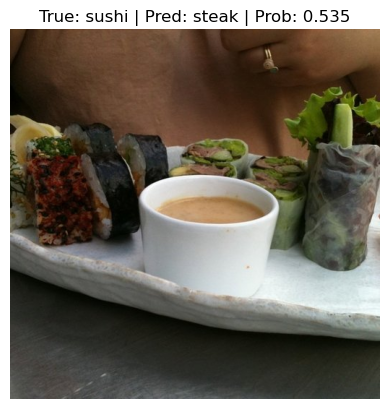

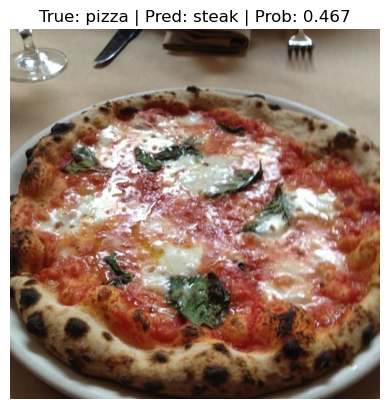

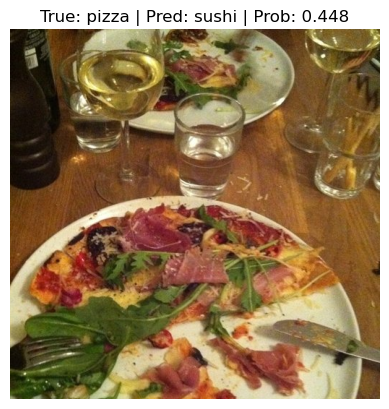

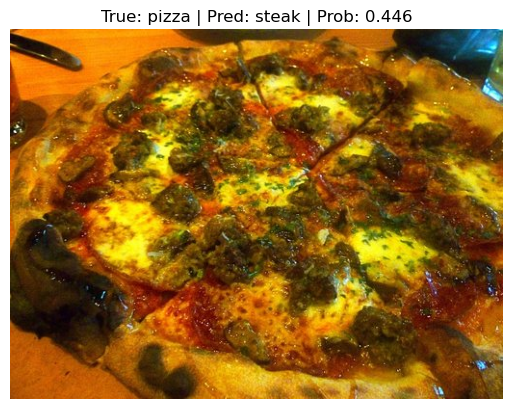

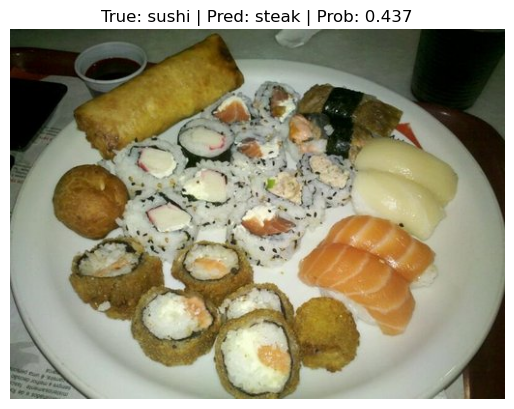

In [58]:
import torchvision
import matplotlib.pyplot as plt

# Plot the top 5 most wrong images
for _, row in top_5_most_wrong.iterrows():
    image_path = row.iloc[0]
    true_label = row.iloc[1]
    pred_prob = row.iloc[2]
    pred_class = row.iloc[3]

    # Read the image
    img = torchvision.io.read_image(str(image_path)).float() / 255.0  # Normalize image

    # Plotting
    plt.figure()
    plt.imshow(img.permute(1, 2, 0))  # [C, H, W] -> [H, W, C]
    plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
    plt.axis('off')
    plt.show()


## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

In [74]:
# TODO: Get an image of pizza/steak/sushi
# Download image of pizza
import requests

def download_image(image_name: str, image_link: str):

    img_path = data_path / image_name
    
    if not img_path.is_file():
        with open(img_path, 'wb') as f:
            request = requests.get(image_link)
            print(f'Downloading {img_path}...')
            f.write(request.content)
    else:
        print(f'{img_path} already exists, skipping download....')

    return img_path 

image_path = download_image('car_image', r'https://imgs.search.brave.com/3SiB3E4ikbfpy9NFygkichDgmejG5iU3gcB2Vvm_EMk/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9zdGF0/aWMudmVjdGVlenku/Y29tL3N5c3RlbS9y/ZXNvdXJjZXMvdGh1/bWJuYWlscy8wMDYv/MjA0LzA2OS9zbWFs/bC90aGUtaGVhZGxp/Z2h0cy1hbmQtdGhl/LWhvb2Qtb2YtYS1u/ZXctbHV4dXJ5LWNh/ci1waG90by5qcGc')

data\car_image already exists, skipping download....


Text(0.5, 1.0, 'steak')

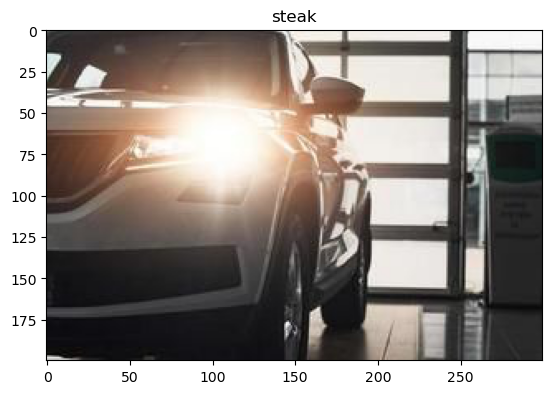

In [79]:
import torchvision

# Read in custom image
custom_image = Image.open(image_path)
transformed_image = simple_transform(custom_image).unsqueeze(dim=0)
model_0.eval()
with torch.inference_mode():
    y_pred = model_0(transformed_image.to(device))

y_label = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
class_names[y_label]

# Let's plot the image
plt.imshow(custom_image)
plt.title(f'{class_names[y_label]}')

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [80]:
# TODO: Recreate a new model 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_1 = torchvision.models.efficientnet_b0(weights=weights).to(device)
model_1

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [82]:
model_1.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1280, out_features=3)
)

In [83]:
for param in model_1.features.parameters():
    param.requires_grad = False

In [84]:
from torchinfo import summary

In [85]:
summary(model_1, input_size=[1, 3, 224, 224])

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 3]                    --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         (864)
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         (64)
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         (1,448)
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-5                                 [1, 24, 56, 56]           (6,004)
│    │    └─MBConv: 3-6                      

In [86]:
# Set the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [87]:
# Train the model for 10 epochs

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# setup timer
from timeit import default_timer as timer
start = timer()

model_1_results = engine.train(model=model_1,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=10,
                               device=device
                              )

# End time 
end = timer()
print(f'[INFO] Total time: {end - start:.3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0671 | train_acc: 0.4180 | test_loss: 0.8784 | test_acc: 0.6932
Epoch: 2 | train_loss: 0.8513 | train_acc: 0.7031 | test_loss: 0.7925 | test_acc: 0.7850
Epoch: 3 | train_loss: 0.7505 | train_acc: 0.8164 | test_loss: 0.7298 | test_acc: 0.7850
Epoch: 4 | train_loss: 0.7143 | train_acc: 0.7461 | test_loss: 0.6414 | test_acc: 0.8570
Epoch: 5 | train_loss: 0.6250 | train_acc: 0.8125 | test_loss: 0.6256 | test_acc: 0.8466
Epoch: 6 | train_loss: 0.5632 | train_acc: 0.9180 | test_loss: 0.5654 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.5147 | train_acc: 0.9297 | test_loss: 0.5353 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.5388 | train_acc: 0.7930 | test_loss: 0.5463 | test_acc: 0.8769
Epoch: 9 | train_loss: 0.5650 | train_acc: 0.8047 | test_loss: 0.5047 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.4746 | train_acc: 0.8086 | test_loss: 0.4196 | test_acc: 0.8655
[INFO] Total time: 239.898 seconds


## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb). 


### Get 20% data

In [88]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

data\pizza_steak_sushi_20_percent directory exists.


(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [89]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [90]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1dd8a1dcb20>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [98]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_2 = torchvision.models.efficientnet_b0(weights=weights).to(device)
model_2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [99]:
# change classifier head
model_2.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1280, out_features=3)
)

In [100]:
for param in model_2.features.parameters():
    param.requires_grad = False

In [101]:
# Setup the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), 
                            lr=0.001)



### Train a model with 20% of the data

In [104]:
# Train the model for 10 epochs

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# setup timer
from timeit import default_timer as timer
start = timer()

model_2.to(device)
model_2_results = engine.train(model=model_2,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=10,
                               device=device
                              )

# End time 
end = timer()
print(f'[INFO] Total time: {end - start:.3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1131 | train_acc: 0.3242 | test_loss: 0.9357 | test_acc: 0.4659
Epoch: 2 | train_loss: 0.8841 | train_acc: 0.7656 | test_loss: 0.8177 | test_acc: 0.7955
Epoch: 3 | train_loss: 0.7881 | train_acc: 0.8086 | test_loss: 0.7380 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.7260 | train_acc: 0.7578 | test_loss: 0.6450 | test_acc: 0.8665
Epoch: 5 | train_loss: 0.6366 | train_acc: 0.7852 | test_loss: 0.6299 | test_acc: 0.8769
Epoch: 6 | train_loss: 0.5583 | train_acc: 0.9180 | test_loss: 0.5569 | test_acc: 0.9072
Epoch: 7 | train_loss: 0.5328 | train_acc: 0.9219 | test_loss: 0.5250 | test_acc: 0.8769
Epoch: 8 | train_loss: 0.5506 | train_acc: 0.7930 | test_loss: 0.5264 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.5821 | train_acc: 0.8008 | test_loss: 0.4910 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.4895 | train_acc: 0.8086 | test_loss: 0.4093 | test_acc: 0.8759
[INFO] Total time: 241.913 seconds


## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [105]:
# Let's use resnets 

weights = torchvision.models.ResNet50_Weights.DEFAULT
model_3 = torchvision.models.resnet50(weights=weights).to(device)
model_3

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [106]:
summary(model_3, input_size=[1, 3, 224, 224])


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

In [108]:
num_features = model_3.fc.in_features  
model_3.fc = nn.Linear(num_features, 3) 

In [112]:
for param in model_3.parameters():
    param.requires_grad = False

for param in model_3.fc.parameters():
    param.requires_grad = True

In [113]:
summary(model_3, input_size=[1, 3, 224, 224])


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 3]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (4,096)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]    

In [114]:
# Train the resnet model for 10 epochs

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3.parameters(), lr=0.001)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# setup timer
from timeit import default_timer as timer
start = timer()

model_3.to(device)
model_3_results = engine.train(model=model_3,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=10,
                               device=device
                              )

# End time 
end = timer()
print(f'[INFO] Total time: {end - start:.3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0759 | train_acc: 0.3203 | test_loss: 1.0063 | test_acc: 0.5180
Epoch: 2 | train_loss: 0.8692 | train_acc: 0.7969 | test_loss: 0.9222 | test_acc: 0.6828
Epoch: 3 | train_loss: 0.7754 | train_acc: 0.8125 | test_loss: 0.8547 | test_acc: 0.7339
Epoch: 4 | train_loss: 0.7001 | train_acc: 0.7773 | test_loss: 0.8055 | test_acc: 0.7945
Epoch: 5 | train_loss: 0.6198 | train_acc: 0.7930 | test_loss: 0.7657 | test_acc: 0.7538
Epoch: 6 | train_loss: 0.5649 | train_acc: 0.8047 | test_loss: 0.7420 | test_acc: 0.7841
Epoch: 7 | train_loss: 0.5205 | train_acc: 0.9570 | test_loss: 0.6747 | test_acc: 0.8769
Epoch: 8 | train_loss: 0.5044 | train_acc: 0.8164 | test_loss: 0.6913 | test_acc: 0.7538
Epoch: 9 | train_loss: 0.4750 | train_acc: 0.8359 | test_loss: 0.6559 | test_acc: 0.8153
Epoch: 10 | train_loss: 0.4165 | train_acc: 0.9531 | test_loss: 0.5653 | test_acc: 0.9375
[INFO] Total time: 250.834 seconds


### WoW achieved 93% accuracy on test set

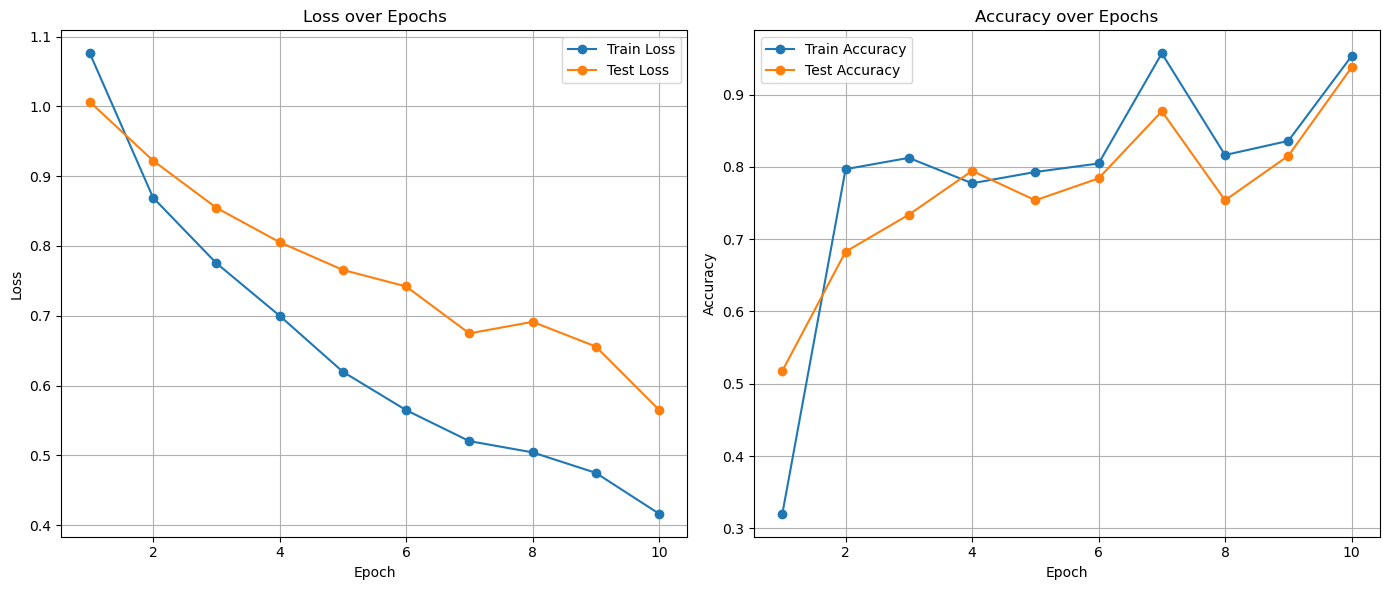

In [116]:
import matplotlib.pyplot as plt


# Create subplots
epochs = range(1, len(model_3_results['train_loss']) + 1)
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, model_3_results['train_loss'], label='Train Loss', marker='o')
plt.plot(epochs, model_3_results['test_loss'], label='Test Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, model_3_results['train_acc'], label='Train Accuracy', marker='o')
plt.plot(epochs, model_3_results['test_acc'], label='Test Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [117]:
# Model is overfitting